In [1]:
# setup chunk

## import libraries
import torch
import torch.nn as nn
import os
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import random
import math

## set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
# Basic block with two convolutional layers
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Overall CNN model architecture
class CNN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CNN, self).__init__()
        self.in_channels = 32

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        # Stacked layers of basic block with increasing number of filters
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        # Average pooling and fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        feature_maps = self.layer4(x)
        x = self.avg_pool(feature_maps)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x, feature_maps


cnn_model = CNN(BasicBlock, [3, 4, 6, 3]).to(device)
model_weights_path = "/kaggle/input/deeplearningproject/data_analysis/data_analysis/cnn_model_weights.pth"
cnn_model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device)))

<All keys matched successfully>

### Visualization on Training Data

In [26]:
folder_paths_training = {
    # 'COCO': '/kaggle/input/deeplearningproject/data_model/data_model/coco_imgs_train',
    'Oxford': '/kaggle/input/deeplearningproject/data_model/data_model/oxford_imgs'
}

# Define image preprocessing steps
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

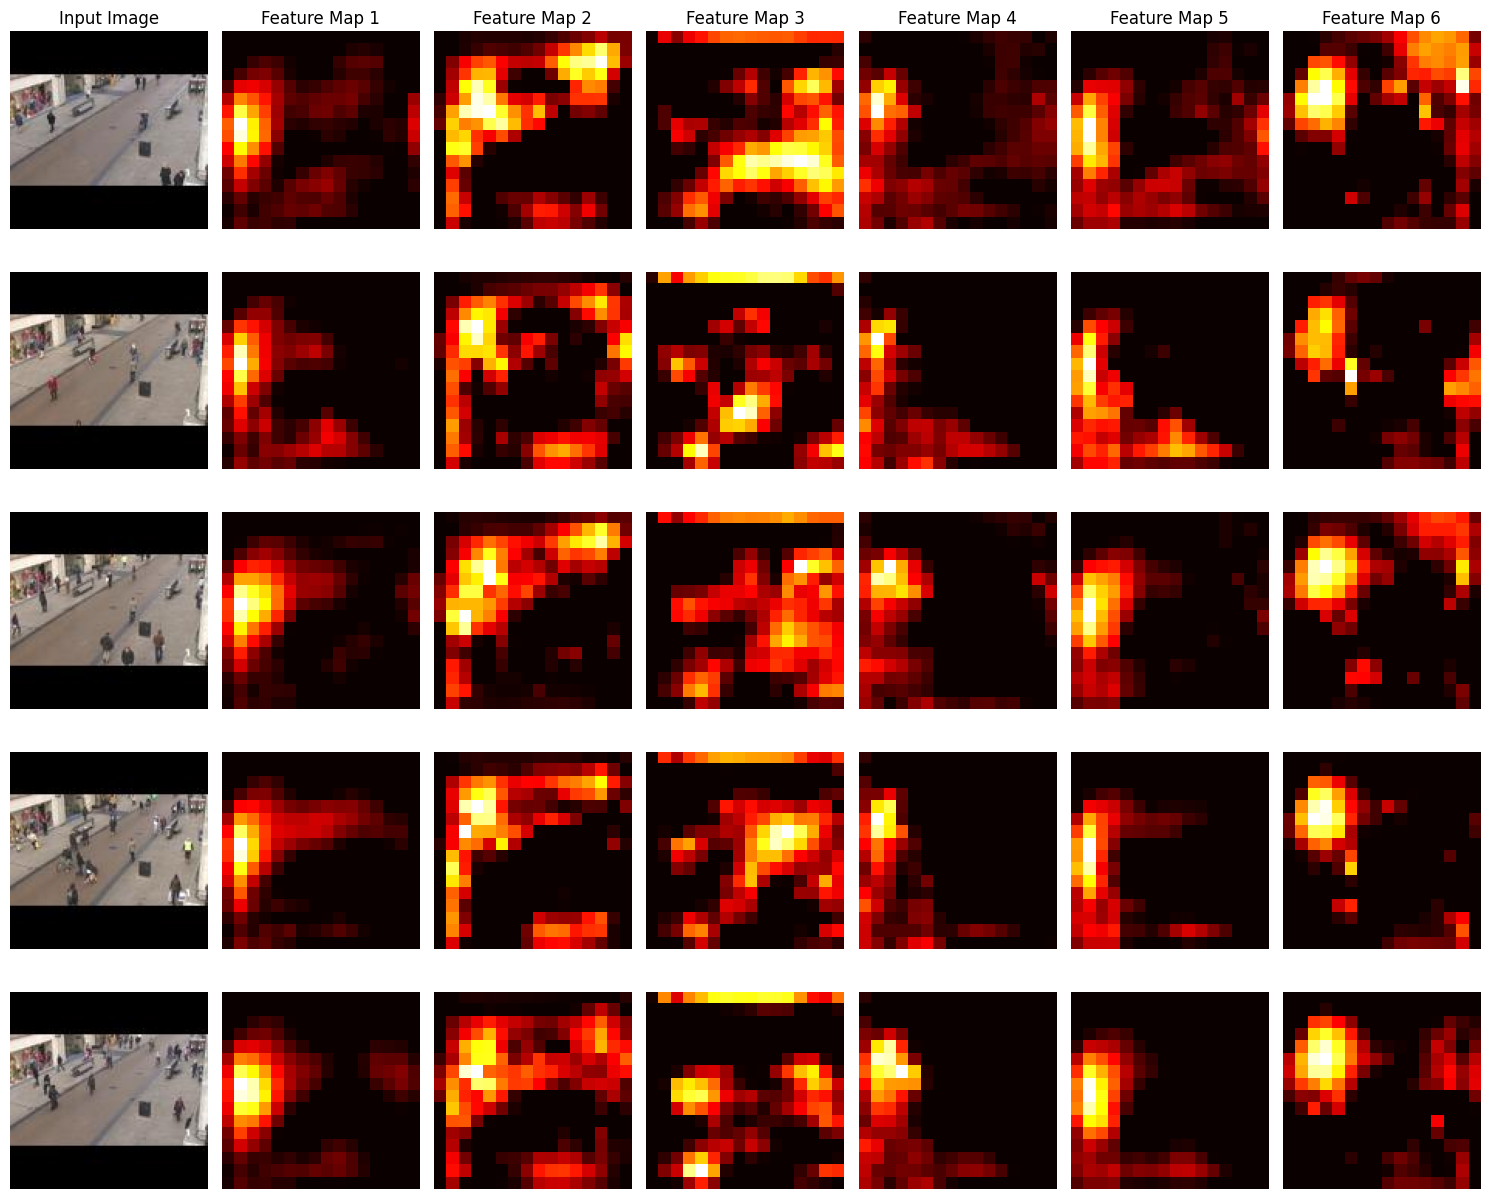

In [27]:
def visualize_features_and_inputs(model, num_images=5, num_maps=5):
    model.eval()  # Set the model to evaluation mode

    # Collect a list of all images from the folders
    all_image_files = []
    for training_set, image_dir in folder_paths_training.items():
        for filename in os.listdir(image_dir):
            if filename.endswith(".jpg"):
                all_image_files.append((training_set, os.path.join(image_dir, filename)))

    # Randomly sample the specified number of images
    selected_images = random.sample(all_image_files, num_images)

    fig, axes = plt.subplots(num_images, num_maps + 1, figsize=(15, 2.5 * num_images))  # +1 for the input image

    for idx, (training_set, image_path) in enumerate(selected_images):
        image = Image.open(image_path).convert('RGB')
        image_tensor = preprocess(image).unsqueeze(0).to(device)

        # Pass the image through the model to get the output and feature maps
        with torch.no_grad():
            _, feature_maps = model(image_tensor)
        feature_maps = feature_maps.cpu().data  # Move feature maps to CPU for visualization

        # Convert the input image tensor back to numpy for visualization
        image_np = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Undo normalization

        # Display the input image
        axes[idx, 0].imshow(image_np)
        axes[idx, 0].set_title('Input Image' if idx == 0 else '')
        axes[idx, 0].axis('off')

        # Display feature maps
        for i in range(num_maps):
            if i < feature_maps.size(1):  # Ensure there are enough feature maps
                fmap = feature_maps[0, i]  # Extract feature map for current image
                # Normalize the feature map to [0, 1] range
                fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min())
                axes[idx, i + 1].imshow(fmap.numpy(), cmap='hot', vmin=0, vmax=1)
                axes[idx, i + 1].set_title(f'Feature Map {i+1}' if idx == 0 else '')
                axes[idx, i + 1].axis('off')
            else:
                axes[idx, i + 1].axis('off')  # Hide unused axes if there are fewer feature maps

    plt.tight_layout()
    plt.show()

# Call the visualization function specifying the number of images and feature maps
visualize_features_and_inputs(cnn_model, num_images=5, num_maps=6)

### Visualization on Earthcam Images

In [17]:
folder_paths_cities = {
    'New York': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/Earthcam_Images/NewYork_resized',
    'New Orleans': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/Earthcam_Images/NewOrleans_resized',
    'London': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/Earthcam_Images/London_resized'
}

# Define image preprocessing steps
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

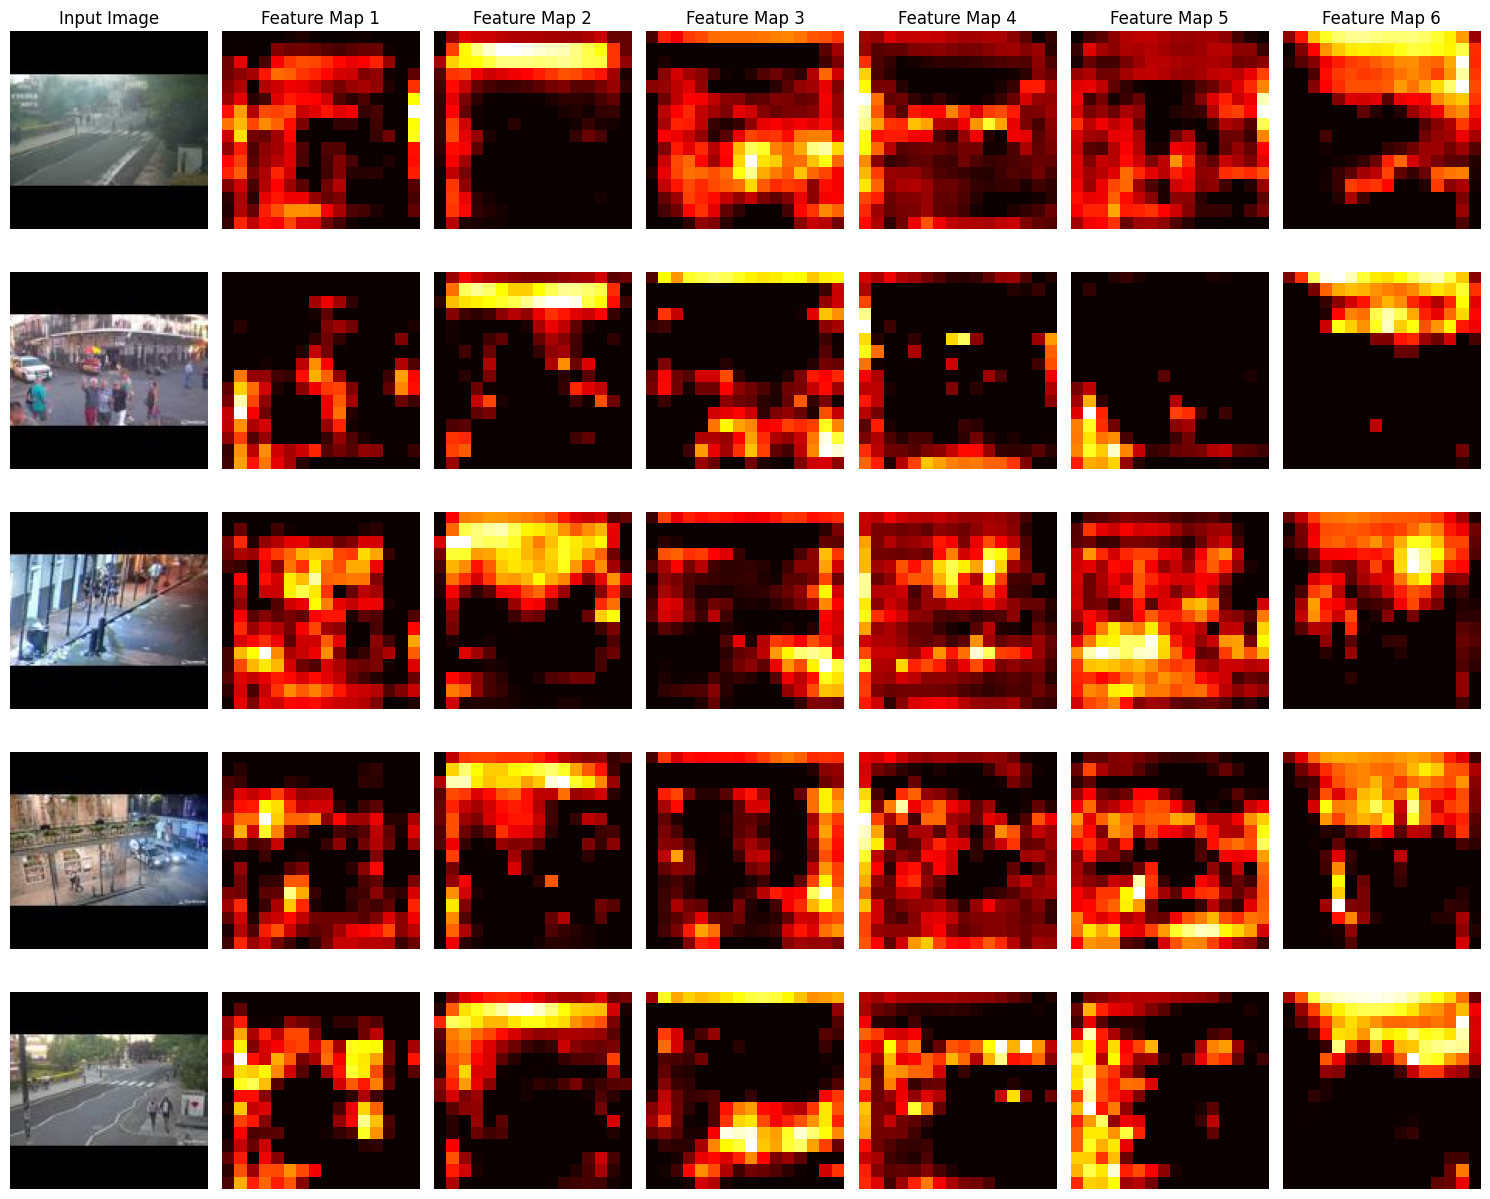

In [18]:
def visualize_features_and_inputs(model, num_images=5, num_maps=5):
    model.eval()  # Set the model to evaluation mode

    # Collect a list of all images from the folders
    all_image_files = []
    for city, image_dir in folder_paths_cities.items():
        for filename in os.listdir(image_dir):
            if filename.endswith(".jpg"):
                all_image_files.append((city, os.path.join(image_dir, filename)))

    # Randomly sample the specified number of images
    selected_images = random.sample(all_image_files, num_images)

    fig, axes = plt.subplots(num_images, num_maps + 1, figsize=(15, 2.5 * num_images))  # +1 for the input image

    for idx, (city, image_path) in enumerate(selected_images):
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        image_tensor = preprocess(image).unsqueeze(0).to(device)

        # Pass the image through the model to get the output and feature maps
        with torch.no_grad():
            _, feature_maps = model(image_tensor)
        feature_maps = feature_maps.cpu().data  # Move feature maps to CPU for visualization

        # Convert the input image tensor back to numpy for visualization
        image_np = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Undo normalization

        # Display the input image
        axes[idx, 0].imshow(image_np)
        axes[idx, 0].set_title('Input Image' if idx == 0 else '')
        axes[idx, 0].axis('off')

        # Display feature maps
        for i in range(num_maps):
            if i < feature_maps.size(1):  # Ensure there are enough feature maps
                fmap = feature_maps[0, i]  # Extract feature map for current image
                # Normalize the feature map to [0, 1] range
                fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min())
                axes[idx, i + 1].imshow(fmap.numpy(), cmap='hot', vmin=0, vmax=1)
                axes[idx, i + 1].set_title(f'Feature Map {i+1}' if idx == 0 else '')
                axes[idx, i + 1].axis('off')
            else:
                axes[idx, i + 1].axis('off')  # Hide unused axes if there are fewer feature maps

    plt.tight_layout()
    plt.show()

# Call the visualization function specifying the number of images and feature maps
visualize_features_and_inputs(cnn_model, num_images=5, num_maps=6)